In [1]:
from highcharts import Highmap
from highcharts import Highchart

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import requests
import seaborn as sns
sns.set_context("talk", font_scale=1.4)

from state_details import electoral_college_votes_by_state, hc_keys_by_state

## Read in population info by age/gender/race/state

In [2]:
# API key requested from www.census.gov
f = open('/Users/brianna/Dropbox/data_project/census_api_key.txt', 'r')
api_key = f.readline()[:-1]
f.close()

In [3]:
# Make dict with details of each variable, as defined in the documentation:
# http://api.census.gov/data/2010/sf1/variables.html
# If we use the variables [A-G], we end up double counting people that identify as "White, Hispanic", for example.
# In order to not double-count people, use the variables where people have identified as "[Race], non-hispanic" 
# This means all people that identify as hispanic will be classified only as hispanic (not any other race they've)
# specified.  But otherwise because of the way the census is constructed we end up double counting 50 million people.
race_codes = {'I': 'white',
              'J': 'black',
              'K': 'native_american',
              'L': 'asian',
              'M': 'pacific_islander',
              'N': 'other',
              'O': 'two_or_more_races',
              'H': 'hispanic'}

census_variables = {}
for r in race_codes:
    age = 0
    for i in range(3, 3 + 101):
        census_variables['PCT012%s%s' % (r, str(i).zfill(3))] = {'age': age, 'gender': 'male', 'race': race_codes[r]}
        age += 1

    age = 0
    for i in range(107, 107 + 101):
        census_variables['PCT012%s%s' % (r, str(i).zfill(3))] = {'age': age, 'gender': 'female', 'race': race_codes[r]}
        age += 1

In [4]:
upload_from_file = True

In [5]:
if upload_from_file:
    population = pd.DataFrame.from_csv('data/population_by_gender_age_race_state_nh.csv')
else:
    # For each variable (ie. each combination of age/gender/race), get the population per state.
    # There are 100*2*8 = 1600 variables here, which means 1600 API calls.
    # In total there will be 1600*50 = 80K rows of data in the final population dataframe.
    population = pd.DataFrame(columns = ['population', 'state', 'age', 'gender', 'race'])
    v_count = 1
    for v in census_variables:
        if v_count%20 == 0:
            print('%s of 1600 variables completed' % v_count)
        # Call the API to get populations by state for this age/gender/race group
        url = 'http://api.census.gov/data/2010/sf1?key=%(api_key)s&get=%(v)s,NAME&for=state:*' % {'v': v, 'api_key': api_key}
        response = requests.get(url)
        data = eval(response.content)

        # Turn the response into a dataframe and make it pretty
        headers = data.pop(0)
        df = pd.DataFrame(data, columns=headers)
        df.drop('state', axis=1, inplace=True)
        df.rename(columns = {v: 'population', 'NAME': 'state'}, inplace=True)
        df['population'] = df.population.apply(lambda x: int(x))

        # Add columns defining the group and append to the final dataframe
        df['age'] = census_variables[v]['age']
        df['gender'] = census_variables[v]['gender']
        df['race'] = census_variables[v]['race']
        population = population.append(df)
        v_count += 1

    population.to_csv('data/population_by_gender_age_race_state_nh.csv')

In [6]:
# Make sure that this sums to the whole US population according to the 2010 census (312 million)
sum(population.population)

312467002

In [29]:
print(sum(population[population.age >= 18].population))
print(sum(population[population.age >= 18].population)/538)
print(237e6/538)
print('\n')
print(sum(population[(population.age >= 18) & (population.state == 'California')].population))
print(sum(population[(population.age >= 18) & (population.state == 'California')].population)/55)
print('\n')
print(sum(population[(population.age >= 18) & (population.state == 'Vermont')].population))
print(sum(population[(population.age >= 18) & (population.state == 'Vermont')].population)/3)

237382240
441230
440520.446097


27958395
508334


496503
165501


## Plot Age distribution by race

In [30]:
gr = population.groupby(['race', 'age']).sum()
gr['race'] = gr.index.get_level_values(0)
gr['age'] = gr.index.get_level_values(1)

race_colors = {'white': 'b',
              'black': 'm',
              'native_american': 'k',
              'asian': 'g',
              'pacific_islander': 'grey',
              'other': 'cyan',
              'two_or_more_races': 'r',
              'hispanic': 'orange'}

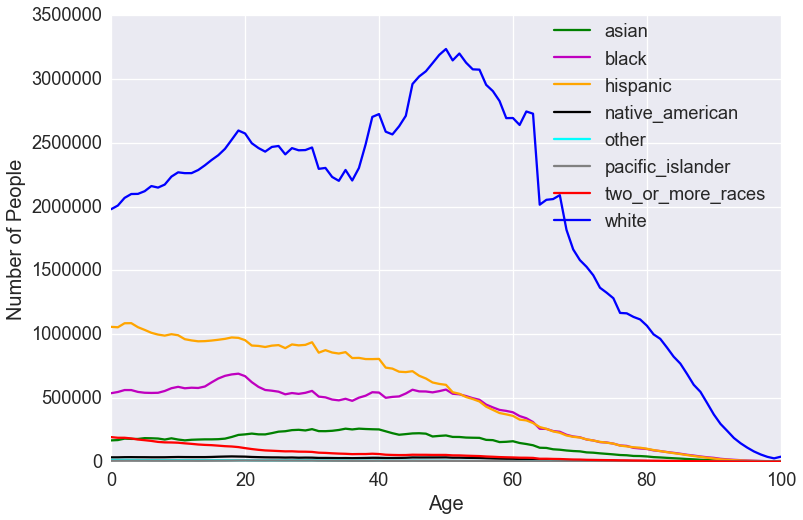

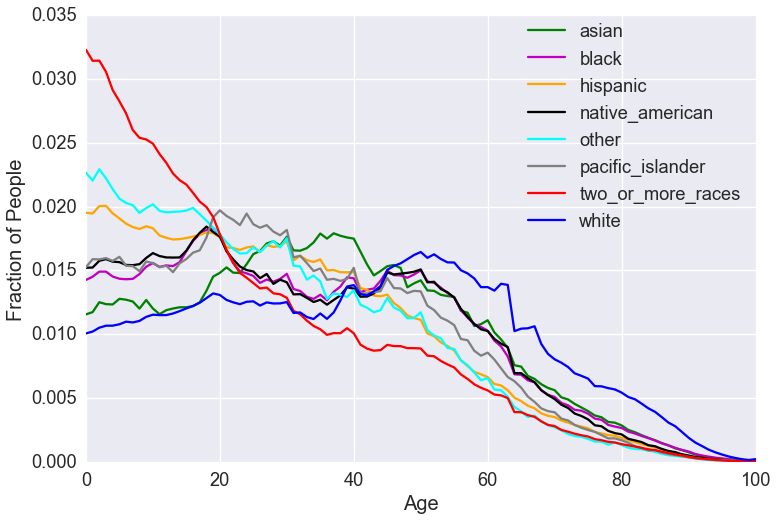

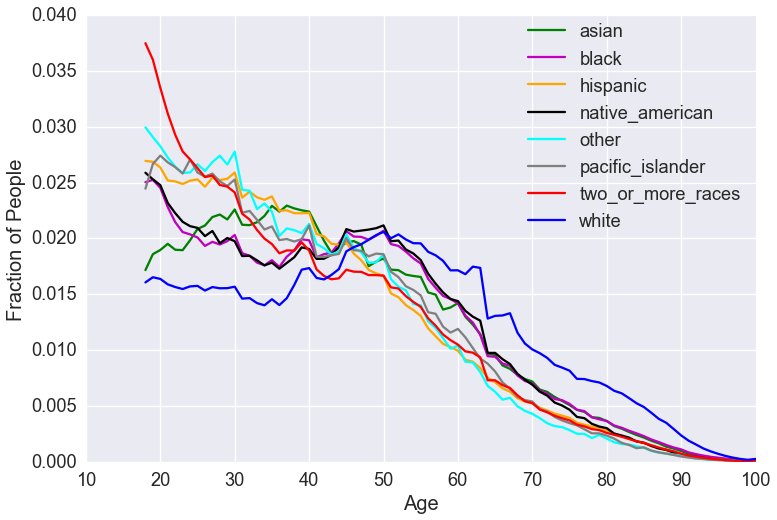

In [16]:
plt.figure(figsize=(12,8))
for r in gr.race.unique():
    plt.plot(gr[gr.race == r].age, gr[gr.race == r].population, label=r, color=race_colors[r])

plt.xlabel('Age')
plt.ylabel('Number of People')
plt.legend(bbox_to_anchor=(.65, 1), loc=2, borderaxespad=0.)
plt.show()

# Plot normalized
plt.figure(figsize=(12,8))
for r in gr.race.unique():
    total_pop = np.sum(gr[gr.race == r].population)
    plt.plot(gr[gr.race == r].age, gr[gr.race == r].population / total_pop, label=r, color=race_colors[r])
plt.xlabel('Age')
plt.ylabel('Fraction of People')
plt.legend(bbox_to_anchor=(.65, 1), loc=2, borderaxespad=0.)
plt.show()

# Plot normalized 18 and up (ie. eligible voters)
plt.figure(figsize=(12,8))
for r in gr.race.unique():
    inclusion = (gr.race == r) & (gr.age >= 18)
    total_pop = np.sum(gr[inclusion].population)
    plt.plot(gr[inclusion].age, gr[inclusion].population / total_pop, label=r, color=race_colors[r])
plt.xlabel('Age')
plt.ylabel('Fraction of People')
plt.legend(bbox_to_anchor=(.65, 1), loc=2, borderaxespad=0.)
plt.show()


I had never realized this before, but white people are the oldest race, on average.  So this idea that white people tend to vote more conservatively might just be because they are older.

## Get Summary Stats for Each State

### Average Age

In [17]:
# Get a weighted average of age by dividing age * population by the population of whatever bin you're interested in
population['age_x_population'] = population.age * population.population

# Get population and average age by state
df = population.groupby('state').sum()
df['ave_age'] = df.age_x_population / df.population
df['ave_age'] = df.ave_age.apply(lambda x: round(x, 1))
df.head()

# Get average age and population of a subset of the whole population
def include_average_age_of_group(df, df_subset, group):
    df_subset['ave_age_%s' % group] = df_subset.age_x_population / df_subset.population
    df_subset['ave_age_%s' % group] = df_subset['ave_age_%s' % group].apply(lambda x: round(x, 1))
    df_subset['population_%s' % group] = df_subset.population

    # Include average_age_eligible in the main dataframe by state
    df = df.merge(df_subset[['population_%s' % group, 'ave_age_%s' % group]], 
                        left_index=True, right_index=True, how='outer')
    return df

# Get average age of just vote-eligible citizens (ie. 18 and over)
eligible = (population.age >= 18)
df_subset = population[eligible].groupby('state').sum()
group = 'eligible'
df = include_average_age_of_group(df, df_subset, group)

# Get average age of just WHITE vote-eligible citizens (ie. 18 and over)
eligible = (population.age >= 18) & (population.race == 'white')
df_subset = population[eligible].groupby('state').sum()
group = 'eligible_white'
df = include_average_age_of_group(df, df_subset, group)

### Percent Urban/Rural

In [18]:
# Population in Urban Areas (60,000+ citizens)
# from American community Survey Year 1 Estimates (2015)
# http://api.census.gov/data/2015/acs1.html
# There's one "null" entry here so replace it with zero so the eval() command doesn't break.
url = 'http://api.census.gov/data/2015/acs1?get=NAME,B01001_001E&for=place:*&key=%s' % api_key 
response = requests.get(url)
data = eval(response.content.replace('null', '"0"'))

# Turn the response into a dataframe and make it pretty
headers = data.pop(0)
urb = pd.DataFrame(data, columns=headers)
urb.rename(columns={'B01001_001E': 'urban_population', 'state': 'state_no'}, inplace=True)
urb['urban_population'] = urb.urban_population.apply(lambda x: int(x))
urb['state'] = urb.NAME.apply(lambda x: x.split(',')[1][1:])

# Get total urban population per state and merge with the main dataframe, df
gr_urban = urb.groupby('state').sum()
df = df.merge(gr_urban[['urban_population']], left_index=True, right_index=True, how='outer')

# Get percentage of population in urban areas.  Some states (like Wyoming)
# have no cities with 60,000+ citizens, so replace Null with 0 in those states.
# DC actually has more urban citizens by this measure than total citizens so
# round it back down to the total number of citizens
df['pct_urban'] = (df.urban_population * 1.0/ df.population).apply(lambda x: round(x * 100, 1))
df.fillna(value=0, inplace=True)
df['pct_urban'][df.pct_urban > 100] = 100
df['pct_rural'] = (100 - df.pct_urban).apply(lambda x: round(x, 1))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Add keys and state abbreviations

In [19]:
# Add hc-keys for plotting in Highcharts
df['state']= df.index
df['hc_key'] = df.state.apply(lambda x: hc_keys_by_state[x])
df['state_abbv'] = df.hc_key.apply(lambda x: x[-2:].upper())

### Percent Voting Republican/Democrat/Libertarian

In [20]:
# Include election results from the past 4 elections to find states that have voted consistently R or D so we can see 
# if EC representation is really different in those states.
for y in ['2004', '2008', '2012', '2016']:
    print('Adding voting data for %s' % y)
    votes = pd.DataFrame.from_csv('data/election_results_%s.csv' % y)

    if y == '2004' or y == '2008':
        # Reshape and clean up from csv
        votes.fillna(value='Total', inplace=True)
        votes = votes[(votes['party%s' % y].isin(['R', 'D', 'Total']))]. \
                       drop('candidate%s' % y, axis=1). \
                       pivot(columns='party%s' % y, values='total%s' % y). \
                       rename(columns={'D': 'votes_dem%s' % y, 'R': 'votes_rep%s' % y, 'Total': 'votes_total%s' % y}). \
                       dropna()

    if y != '2016':
        # Convert strings to integers and get percentage votes for each party
        votes['votes_dem%s' % y] = votes['votes_dem%s' % y].apply(lambda x: int(x.replace(',', '')))
        votes['votes_rep%s' % y] = votes['votes_rep%s' % y].apply(lambda x: int(x.replace(',', '')))
        votes['votes_total%s' % y] = votes['votes_total%s' % y].apply(lambda x: int(x.replace(',', '')))

    votes['pct_dem%s' % y] = (votes['votes_dem%s' % y] / votes['votes_total%s' % y]).apply(lambda x: round(x * 100, 1))
    votes['pct_rep%s' % y] = (votes['votes_rep%s' % y] / votes['votes_total%s' % y]).apply(lambda x: round(x * 100, 1))
    
    votes['pct_dem_rep_gap%s' % y] = votes['pct_dem%s' % y] - votes['pct_rep%s' % y]
    votes['pct_dem_rep_gap_abs%s' % y] = votes['pct_dem_rep_gap%s' % y].apply(lambda x: abs(x))

    # Determine if Republicans or Democrats won the state
    votes['r_wins%s' % y] = votes['votes_dem%s' % y] < votes['votes_rep%s' % y]
    assign_winner = {True: 'republican', False: 'democrat'}
    votes['winner%s' % y] = votes['r_wins%s' % y].apply(lambda x: assign_winner[x])
    
    # Merge with main dataframe
    votes['state'] = votes.index
    df = df.merge(votes, on='state', how='outer')
    
# Find the number of states who have voted consistently D or R in the last 4 elections, and the states
# that have swung
df['r_wins_last4'] = df['r_wins2004'] + df['r_wins2008'] +df['r_wins2012'] +df['r_wins2016'] 
df.groupby('r_wins_last4').count()

Adding voting data for 2004
Adding voting data for 2008
Adding voting data for 2012
Adding voting data for 2016


,population,age,age_x_population,ave_age,population_eligible,ave_age_eligible,population_eligible_white,ave_age_eligible_white,urban_population,pct_urban,...,votes_total2016,votes_dem2016,votes_rep2016,votes_lib2016,pct_dem2016,pct_rep2016,pct_dem_rep_gap2016,pct_dem_rep_gap_abs2016,r_wins2016,winner2016
r_wins_last4,,,,,,,,,,,,,,,,,,,,,
0,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
1,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


In [21]:
# Redefine the index of the dataframe by state
df.index = df['state']

### Percent of Population that is White (non-Hispanic)

In [22]:
pct_race = population[population.race == r].groupby('state').sum()
pct_race = pct_race.rename(columns = {'population': '%s_population' % r})


In [23]:
# Get the percentage of the state by race
for code in race_codes:
    r = race_codes[code]
    pct_race = population[population.race == r].groupby('state').sum()
    pct_race = pct_race.rename(columns = {'population': '%s_population' % r})

    df = df.merge(pct_race[['%s_population' % r]], left_index=True, right_index=True, how='outer')
    df['pct_%s' % r] = (df['%s_population' % r] / df.population).apply(lambda x: round(x * 100, 1))

    # And get the percentage of citizens 18+ that identify as this race
    pct_race_eligible = population[(population.race == r) & (population.age >= 18)].groupby('state').sum()
    pct_race_eligible = pct_race_eligible.rename(columns = {'population': '%s_population_eligible' % r})

    df = df.merge(pct_race_eligible[['%s_population_eligible' % r]], 
                  left_index=True, right_index=True, how='outer')
    df['pct_%s_eligible' % r] = (df['%s_population_eligible' % r] / df.population_eligible).apply(lambda x: round(x * 100, 1))

## Add Electoral College Data By State

In [24]:
df['state']= df.index

df['ec_votes'] = df.state.apply(lambda x: electoral_college_votes_by_state[x])
df['ec_votes_per_voter'] = df.ec_votes / df.population_eligible
df['voters_per_ec_vote'] = (df.population_eligible / df.ec_votes).apply(lambda x: round(x))

# These numbers are so small that they're kind of hard to understand so instead let's get 
# the "average" portion of an electoral college vote and look at percentage more or less 
# than that.
ave_ec_votes_per_voter = sum(df.ec_votes) * 1.0 / sum(df.population_eligible)
df['ec_representation_pct_ave'] = df.ec_votes_per_voter.apply(lambda x: round(x * 100.0 / ave_ec_votes_per_voter))

# And let's add representation in the senate just for fun, since over-representation of rural, white states
# in the senate is another common belief.
df['voters_per_senate_seat'] = (df.population_eligible / 2).apply(lambda x: round(x))
df = df.set_value('District of Columbia', 'voters_per_senate_seat', 0)
df = df.set_value('Puerto Rico', 'voters_per_senate_seat', 0)

num_senators = 100
ave_senate_representation = num_senators * 1.0 / sum(df.population_eligible)
def get_senate_representation(x):
    state_senate_representation = 2.0 / x
    return round(state_senate_representation * 100.0 / ave_senate_representation)
df['senate_representation_pct_ave'] = df.population_eligible.apply(lambda x: get_senate_representation(x))
df = df.set_value('District of Columbia', 'senate_representation_pct_ave', 0)
df = df.set_value('Puerto Rico', 'senate_representation_pct_ave', 0)

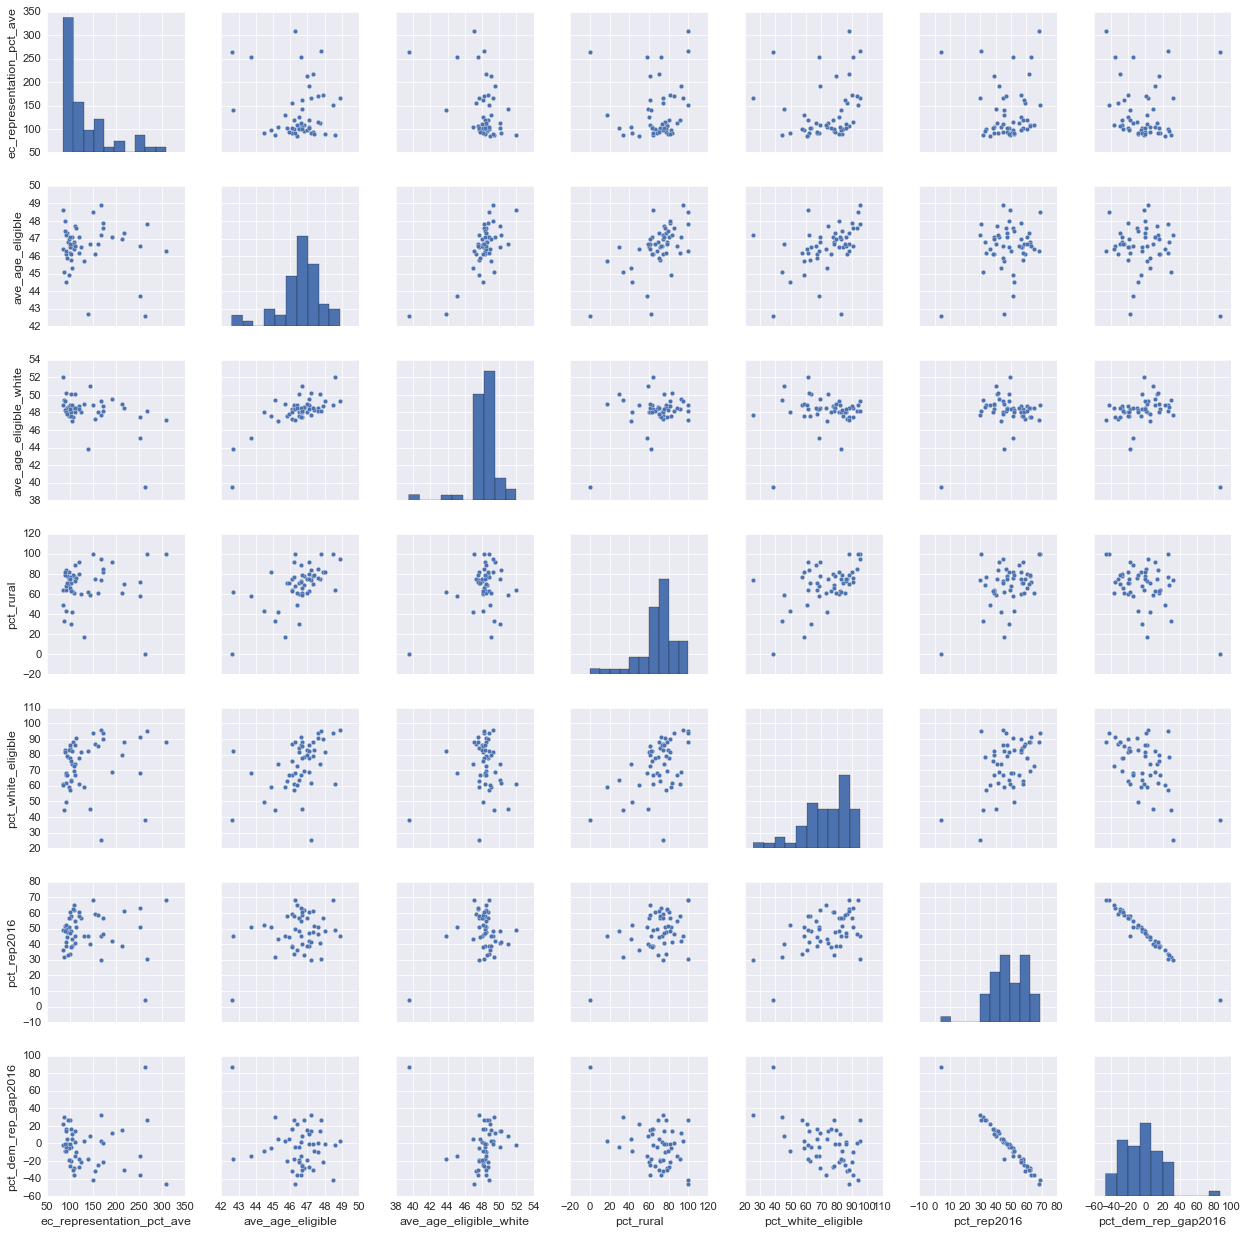

In [17]:
from pandas.tools.plotting import scatter_matrix
columns = ['ec_representation_pct_ave', 'ave_age_eligible', 'ave_age_eligible_white', 
           'pct_rural', 'pct_white_eligible', 'pct_rep2016', 'pct_dem_rep_gap2016']
sns.set_context("paper", font_scale=1.4)
sns.pairplot(df[columns][df.state != 'Puerto Rico']);

In [31]:
# Fill in the data structure for plotting
data = []

plot_titles = {'population': 'US Population by State',
               'ec_votes_per_voter': 'Electoral College Vote Portion Per Voter',
               'ec_representation_pct_ave': 'Electoral College Representation Per Voter (vs. National Average)',
               'senate_representation_pct_ave': 'Senate Representation Per Voter (vs. National Average)',
               'pct_dem': 'Percent Voting Democrat 2016',
               'winner': 'Winner'}

# plot_measure = 'population'
# plot_measure = 'ec_votes_per_voter'
plot_measure = 'ec_representation_pct_ave'
# plot_measure = 'pct_rep'
# plot_measure = 'winner'

for s in df.index:
    if hc_keys_by_state[s] !='us-pr':
        data.append({'hc-key': hc_keys_by_state[s], 'value': df[plot_measure][s]})

In [32]:
# Set colors
blue = 'rgba(119, 152, 191, .5)'
red = 'rgba(223, 83, 83, .5)'
purple = 'rgba(88, 24, 69, .5)'
magenta = 'rgba(188, 10, 209, -.5)'
darkpurple = '#581845'
darkmagenta = '#BC0AD1'

In [33]:
options = {'chart' :{'renderTo' : 'container'},
           'title' : {'text' : plot_titles[plot_measure]},
           'mapNavigation': {'enabled': True, 'buttonOptions': {'verticalAlign': 'bottom'}},
           'colorAxis': {'type': 'linear',
                         'minColor': '#FFFFFF', # white
                         'maxColor': darkpurple},
            'tooltip': {'valueSuffix': '%'},
} 

In [34]:
H = Highmap(width = 650, height = 500)

H.set_dict_options(options) # set options
H.add_data_set(data, 'map', 'Electoral College Representation (vs National Average)', joinBy='hc-key', # set dataset [label string in json, label string in local dicts]
               states={'hover': {'color': '#FFC300'}},
               dataLabels={'enabled': True, 'format': '{point.properties.postal}'})

# source is javascript link from http://code.highcharts.com/mapdata/
H.set_map_source('http://code.highcharts.com/mapdata/countries/us/us-all.js')

# H.save_file(plot_measure)
# H.save_file('ec_representation_per_voter_us_map')

H

In [35]:
plot_measure = 'senate_representation_pct_ave'

for s in df.index:
    if hc_keys_by_state[s] !='us-pr':
        data.append({'hc-key': hc_keys_by_state[s], 'value': df[plot_measure][s]})

In [36]:
options = {'chart' :{'renderTo' : 'container'},
           'title' : {'text' : plot_titles[plot_measure]},
           'mapNavigation': {'enabled': True, 'buttonOptions': {'verticalAlign': 'bottom'}},
           'colorAxis': {'type': 'linear',
                         'minColor': '#FFFFFF', # white
                         'maxColor': darkpurple},
            'tooltip': {'valueSuffix': '%'},
} 

H = Highmap(width = 650, height = 500)

H.set_dict_options(options) # set options
H.add_data_set(data, 'map', 'Senate Representation (vs National Average)', joinBy='hc-key', # set dataset [label string in json, label string in local dicts]
               states={'hover': {'color': '#FFC300'}},
               dataLabels={'enabled': True, 'format': '{point.properties.postal}'})

# source is javascript link from http://code.highcharts.com/mapdata/
H.set_map_source('http://code.highcharts.com/mapdata/countries/us/us-all.js')

# H.save_file(plot_measure)
H

### Does this over-representation consistently benefit any particular demographic?

In [37]:
measure_titles = {'ave_age_eligible': 'Average Age of Eligible Voters in State',
                  'ave_age_white_eligible': 'Average Age of Eligible White Voters in State',
                  'pct_white_eligible': 'Percent of White Eligible Voters in State',
                  'pct_rural': 'Percent of State Population that is Rural',
                  'pct_dem2016': 'Percent of Population that voted Democratic in 2016 election',
                  'pct_rep2016': 'Percent of Population that voted Republican in 2016 election',
                  'population': 'State Population',
                  'pct_dem_rep_gap_abs2016': 'Level of Partisanship in State (Disparity in Votes Per Party)',
                  'r_wins_last4': 'Number of the Last 4 Elections Where the State Voted Republican',
                  'ec_representation_pct_ave': 'Electoral College Over/Under-Representation (%)',
                  'senate_representation_pct_ave': 'Senate Over/Under-Representation (%)',
                  'voters_per_ec_vote': 'Number of Voters Per Electoral College Vote',
                  'voters_per_senate_seat': 'Number of Voters Per US Senate Seat',
                  'population_eligible': 'Number of Citizens age 18+ in State'
            }


In [38]:
# Construct the data structure
x_measure = 'pct_white_eligible'
y_measure = 'pct_rural'
z_measure = 'ec_representation_pct_ave'
data = []
for s in df.index:
    if s != 'Puerto Rico':
        data.append({'x': df[x_measure][s], 
                     'y': df[y_measure][s],
                     'z': df[z_measure][s],
                     'name': hc_keys_by_state[s][-2:].upper(),
                     'color': darkpurple})
        
# Define the options of the chart
options = { # construct option dict
  'chart' :{ 'renderTo' : 'container', 'zoomType': 'xy'},
  'title' : {'text' : 'Electoral College Representation By State Demographics'},
  'xAxis': {'title': {'text': measure_titles[x_measure]}},
  'yAxis': {'title': {'text': measure_titles[y_measure]}},
  'tooltip': {
            'useHTML': True,
            'headerFormat': '<table>',
            'pointFormat': '<tr><th colspan="2"><h3>{point.country}</h3></th></tr>' +
                '<tr><th>Percent White:</th><td>{point.x}%</td></tr>' +
                '<tr><th>Percent Rural:</th><td>{point.y}%</td></tr>' +
                '<tr><th>Electoral College Representation:</th><td>{point.z}%</td></tr>',
            'footerFormat': '</table>',
            'followPointer': True
        },
    
} 

# Plot the chart
H = Highchart(width = 650, height = 500)

H.set_dict_options(options) # set options
H.add_data_set(data, 'bubble', ' ',
                dataLabels={
                    'enabled': True,
                    'format': '{point.name}',
                },
              )
# H.save_file('electoral_college_race_age')
H

In [39]:
# Construct the data structure
x_measure = 'pct_white_eligible'
y_measure = 'pct_rural'
z_measure = 'senate_representation_pct_ave'
data = []
for s in df.index:
    if s != 'Puerto Rico':
        data.append({'x': df[x_measure][s], 
                     'y': df[y_measure][s],
                     'z': df[z_measure][s],
                     'name': hc_keys_by_state[s][-2:].upper(),
                     'color': darkpurple})
        
# Define the options of the chart
options = { # construct option dict
  'chart' :{ 'renderTo' : 'container', 'zoomType': 'xy'},
  'title' : {'text' : 'Senate Representation By State Demographics'},
  'xAxis': {'title': {'text': measure_titles[x_measure]}},
  'yAxis': {'title': {'text': measure_titles[y_measure]}},
  'tooltip': {
            'useHTML': True,
            'headerFormat': '<table>',
            'pointFormat': '<tr><th colspan="2"><h3>{point.country}</h3></th></tr>' +
                '<tr><th>Percent White:</th><td>{point.x}%</td></tr>' +
                '<tr><th>Percent Rural:</th><td>{point.y}%</td></tr>' +
                '<tr><th>Senate Representation:</th><td>{point.z}%</td></tr>',
            'footerFormat': '</table>',
            'followPointer': True
        },
} 

# Plot the chart
H = Highchart(width = 650, height = 500)

H.set_dict_options(options) # set options
H.add_data_set(data, 'bubble', ' ',
                dataLabels={
                    'enabled': True,
                    'format': '{point.name}'
                })
# H.save_file('electoral_college_race_age')
H

## Does over-representation benefit a particular political party?

In [40]:
# Color-code coordinates by the number of the last 4 elections in which the state voted for a Republican
vote_colors_hc = {0: blue, 1: purple, 2: purple, 3: purple, 4: red}

In [41]:
# Construct data structure
x_measure = 'pct_white_eligible'
y_measure = 'pct_rural'
z_measure = 'ec_representation_pct_ave'
data = []
for s in df.index:
    if s != 'Puerto Rico':
        data.append({'x': df[x_measure][s], 
                     'y': df[y_measure][s],
                     'z': df[z_measure][s],
                     'name': hc_keys_by_state[s][-2:].upper(),
                     'color': vote_colors_hc[df['r_wins_last4'][s]],
                     'r_wins_last4': df['r_wins_last4'][s],
                     'state': s})

# construct option dict
options = { 
  'chart' :{ 'renderTo' : 'container', 'zoomType': 'xy'},
  'title' : {'text' : 'Electoral College Representation By State Demographics'},
  'xAxis': {'title': {'text': measure_titles[x_measure]}},
  'yAxis': {'title': {'text': measure_titles[y_measure]}},
  'tooltip': {
            'useHTML': True,
            'headerFormat': '<table>',
            'pointFormat': '<tr><th colspan="2"><h3>{point.name}</h3></th></tr>' +
                '<tr><th>Percent White:</th><td>{point.x}%</td></tr>' +
                '<tr><th>Percent Rural:</th><td>{point.y}%</td></tr>' +
                '<tr><th>Number of Last 4 Elections That Voted Republican:</th><td>{point.r_wins_last4}/4</td></tr>' + 
                '<tr><th>Electoral College Representation:</th><td>{point.z}%</td></tr>',
            'footerFormat': '</table>',
            'followPointer': True
        },
} 

# Plot data
H = Highchart(width = 650, height = 500)

H.set_dict_options(options) # set options
H.add_data_set(data, 'bubble', 'Electoral College Over/Under-Representation',
                dataLabels={
                    'enabled': True,
                    'format': '{point.name}'
                },
                )
H.save_file('ec_representation_per_voter_race_rural_party')
H

In [42]:
# Construct data structure
x_measure = 'pct_white_eligible'
y_measure = 'pct_rural'
z_measure = 'senate_representation_pct_ave'
data = []
for s in df.index:
    if s != 'Puerto Rico':
        data.append({'x': df[x_measure][s], 
                     'y': df[y_measure][s],
                     'z': df[z_measure][s],
                     'name': hc_keys_by_state[s][-2:].upper(),
                     'color': vote_colors_hc[df['r_wins_last4'][s]],
                     'r_wins_last4': df['r_wins_last4'][s],
                     'state': s})

# construct option dict
options = { 
  'chart' :{ 'renderTo' : 'container', 'zoomType': 'xy'},
  'title' : {'text' : 'Senate Representation By State Demographics'},
  'xAxis': {'title': {'text': measure_titles[x_measure]}},
  'yAxis': {'title': {'text': measure_titles[y_measure]}},
  'tooltip': {
            'useHTML': True,
            'headerFormat': '<table>',
            'pointFormat': '<tr><th colspan="2"><h3>{point.name}</h3></th></tr>' +
                '<tr><th>Percent White:</th><td>{point.x}%</td></tr>' +
                '<tr><th>Percent Rural:</th><td>{point.y}%</td></tr>' +
                '<tr><th>Number of Last 4 Elections That Voted Republican:</th><td>{point.r_wins_last4}/4</td></tr>' + 
                '<tr><th>Electoral College Representation:</th><td>{point.z}%</td></tr>',
            'footerFormat': '</table>',
            'followPointer': True
        },
} 

# Plot data
H = Highchart(width = 650, height = 500)

H.set_dict_options(options) # set options
H.add_data_set(data, 'bubble', 'Senate Over/Under-Representation',
                dataLabels={
                    'enabled': True,
                    'format': '{point.name}'
                },
                )
# H.save_file('senate_race_rural_party')
H

## Statistical Analysis
#### Does Age, Race, Fraction Rural, Party Affiliation  relate to EC Over-Representation?
- Later include Income, Education Level

In the last 4 elections, 17 states voted consistently Democrat, 22 voted consistently Republican, and 12 swung.  Of the states that voted consistently, is there overrepresentation of EC for one party over the other?

In [48]:
df.winner2016

state
Alabama                 republican
Alaska                  republican
Arizona                 republican
Arkansas                republican
California                democrat
Colorado                  democrat
Connecticut               democrat
Delaware                  democrat
District of Columbia      democrat
Florida                 republican
Georgia                 republican
Hawaii                    democrat
Idaho                   republican
Illinois                  democrat
Indiana                 republican
Iowa                    republican
Kansas                  republican
Kentucky                republican
Louisiana               republican
Maine                     democrat
Maryland                  democrat
Massachusetts             democrat
Michigan                republican
Minnesota                 democrat
Mississippi             republican
Missouri                republican
Montana                 republican
Nebraska                republican
Nevada        

In [49]:
# The numbers are small (17 vs 22) and the distributions aren't completely normal, but let's do a t-test just to check.
def plot_means(variable):
    from scipy import stats
    import numpy as np

    print('Mean, Median by Voting Record for %s:' % variable)
    print('Democratic states: %s,%s' % (round(np.mean(df[variable][df.r_wins_last4 == 0])),
                                        round(np.median(df[variable][df.r_wins_last4 == 0]))))
    print('Republican states: %s, %s' % (round(np.mean(df[variable][df.r_wins_last4 == 4])),
                                     round(np.median(df[variable][df.r_wins_last4 == 4]))))
    print('Swing States: %s, %s' % (round(np.mean(df[variable][df.r_wins_last4.isin([1,2,3])])),
                                 round(np.median(df[variable][df.r_wins_last4.isin([1,2,3])]))))
    
    print('Democratic Last Election: %s,%s' % (round(np.mean(df[variable][df.winner2016 == 'democrat'])),
                                        round(np.median(df[variable][df.winner2016 == 'democrat']))))
    print('Republican Last Election: %s, %s' % (round(np.mean(df[variable][df.winner2016 == 'republican'])),
                                     round(np.median(df[variable][df.winner2016 == 'republican']))))

    
    t, p = stats.ttest_ind(df[variable][df.r_wins_last4 == 0],
                          df[variable][df.r_wins_last4 == 4],
                          equal_var=False)
    print ('P-value of difference: %s' % p)

Mean, Median by Voting Record for ec_representation_pct_ave:
Democratic states: 142.0,110.0
Republican states: 146.0, 120.0
Swing States: 103.0, 97.0
Democratic Last Election: 138.0,110.0
Republican Last Election: 132.0, 109.0
P-value of difference: 0.864288518375


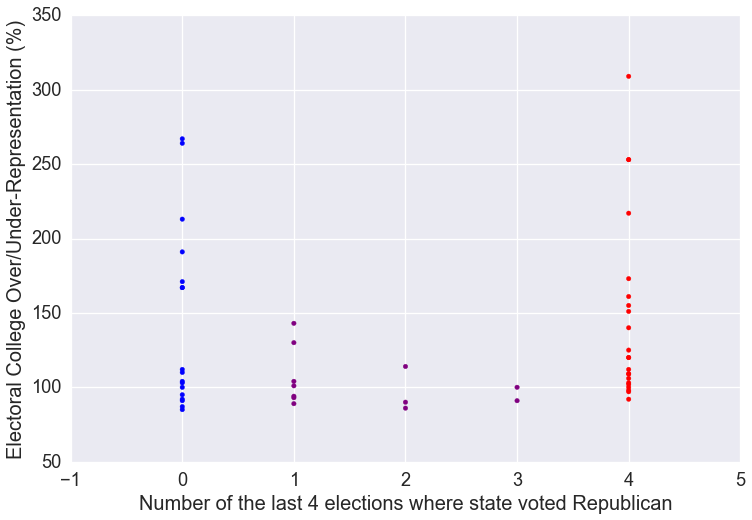

Mean, Median by Voting Record for population_eligible:
Democratic states: 5266483.0,2964580.0
Republican states: 3256999.0, 2208035.0
Swing States: 6114639.0, 5511333.0
Democratic Last Election: 4907476.0,2964580.0
Republican Last Election: 4383429.0, 3365632.0
P-value of difference: 0.296574165611


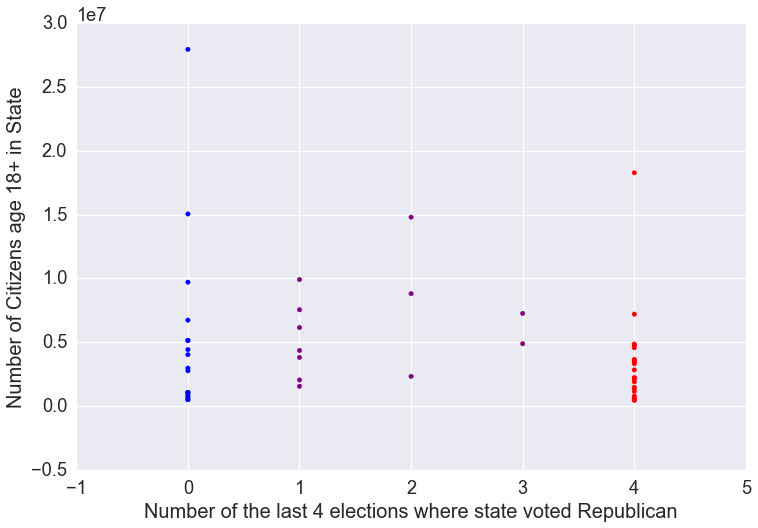

Mean, Median by Voting Record for senate_representation_pct_ave:
Democratic states: 264.0,118.0
Republican states: 337.0, 215.0
Swing States: 118.0, 87.0
Democratic Last Election: 249.0,125.0
Republican Last Election: 270.0, 141.0
P-value of difference: 0.448024148124


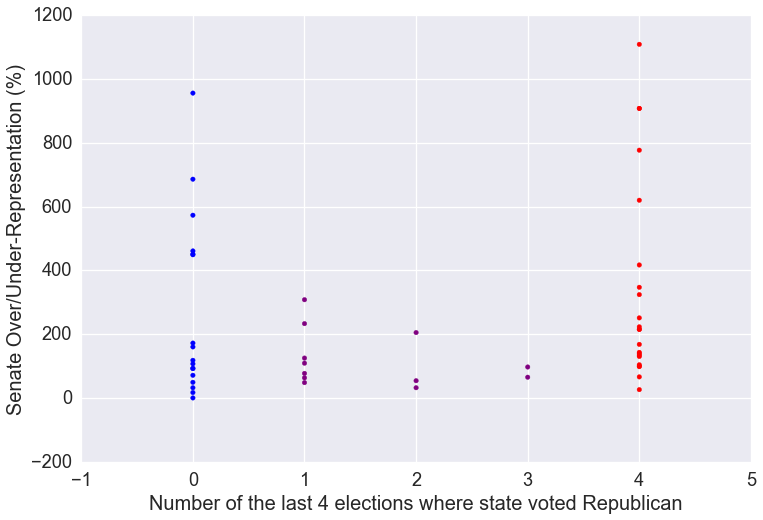

Mean, Median by Voting Record for voters_per_ec_vote:
Democratic states: 359080.0,401978.0
Republican states: 341453.0, 368006.0
Swing States: 438082.0, 457217.0
Democratic Last Election: 364152.0,401978.0
Republican Last Election: 374204.0, 404169.0
P-value of difference: 0.640983856682


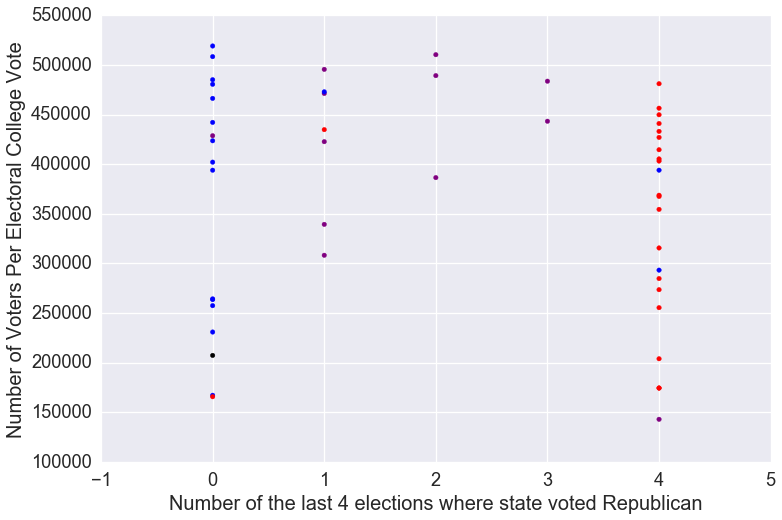

Mean, Median by Voting Record for voters_per_senate_seat:
Democratic states: 2618510.0,1482290.0
Republican states: 1628500.0, 1104018.0
Swing States: 3057320.0, 2755667.0
Democratic Last Election: 2441812.0,1482290.0
Republican Last Election: 2191715.0, 1682816.0
P-value of difference: 0.304792890544


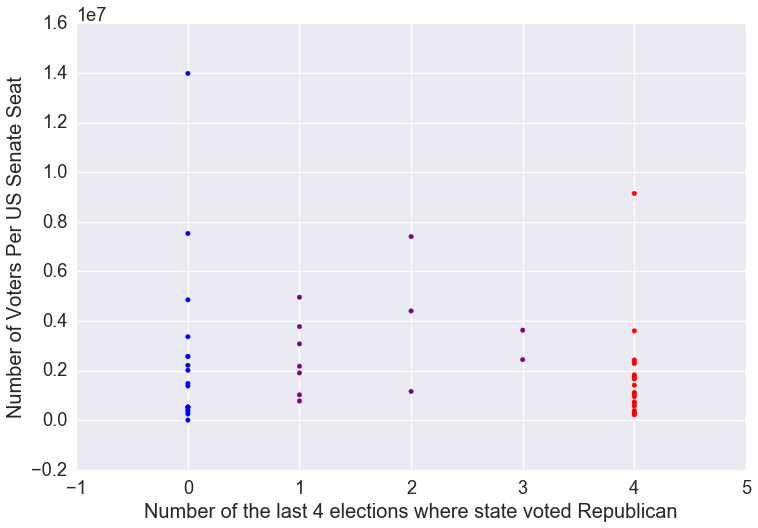

In [50]:
vote_colors_plt = {0: 'b', 1: 'purple', 2: 'purple', 3: 'purple', 4: 'r'}

# variables = {}'ec_representation_pct_ave': 'Over-representation of the state in Electoral College',
#              'voters_per_ec_vote': 'Number of Voters Per Electoral College Vote',
#              'senate_representation_pct_ave': 'Over-representation of the state in the Senate',
#              'voters_per_senate_seat': 'Number of Voters Per US Senate Seat',
#              'population_eligible': 'Number of Citizens age 18+ in State'
#             }
variables = ['ec_representation_pct_ave',
             'voters_per_ec_vote',
             'senate_representation_pct_ave',
             'voters_per_senate_seat',
             'population_eligible'
            ]
for v in sorted(variables):
    plot_means(v)
    plt.figure(figsize=(12,8))
    plt.scatter(df.r_wins_last4, df[v], 
                color=df.r_wins_last4.apply(lambda x: vote_colors_plt.get(x, 'k')))
    plt.xlabel('Number of the last 4 elections where state voted Republican')
    plt.ylabel(measure_titles[v])
    plt.show()

In [51]:
def make_plot(y_measure, y_name):
    x_measure = 'r_wins_last4'
    data = []
    for s in df.index:
        if ((s != 'Puerto Rico')):
            data.append({'x': df[x_measure][s], 
                         'y': df[y_measure][s],
                         'name': hc_keys_by_state[s][-2:].upper(),
                         'color': vote_colors_hc[df['r_wins_last4'][s]]})

    options = { # construct option dict
      'chart' :{ 'renderTo' : 'container', 'zoomType': 'xy'},
      'title' : {'text' : y_name},
      'xAxis': {'title': {'text': measure_titles[x_measure]}},
      'yAxis': {'title': {'text': measure_titles[y_measure]}},
      'tooltip': {
                'useHTML': True,
                'headerFormat': '<table>',
                'pointFormat': '{point.name}: {point.y}% ',
                'footerFormat': '</table>',
                'followPointer': True
            },
    } 

    H = Highchart(width = 650, height = 500)

    H.set_dict_options(options) # set options
    H.add_data_set(data, 'scatter', y_name,
                   dataLabels={'enabled': False, 'format': '{point.name}'})
    return H

In [140]:
H = make_plot('ec_representation_pct_ave','Electoral College Representation By State Voting Behavior')
plot_means('ec_representation_pct_ave')
# H.save_file('ec_representation_by_last_4_elections')
H

Mean, Median by Voting Record for ec_representation_pct_ave:
Democratic states: 142.0,110.0
Republican states: 146.0, 120.0
Swing States: 103.0, 97.0
P-value of difference: 0.864288518375


In [103]:
H = make_plot('senate_representation_pct_ave','Senate Representation By State Demographics')
plot_means('senate_representation_pct_ave')
H

Mean, Median by Voting Record for senate_representation_pct_ave:
Democratic states: 264.0,118.0
Republican states: 337.0, 215.0
Swing States: 118.0, 87.0
P-value of difference: 0.448024148124


In [142]:
H = make_plot('voters_per_ec_vote','Number of Voters Per Electoral College Vote')
plot_means('voters_per_ec_vote')
H.save_file('voters_per_ec_vote_by_last_4_elections')
H

Mean, Median by Voting Record for voters_per_ec_vote:
Democratic states: 359080.0,401978.0
Republican states: 341453.0, 368006.0
Swing States: 438082.0, 457217.0
P-value of difference: 0.640983856682


In [109]:
H = make_plot('voters_per_senate_seat','Number of Voters Per US Senate Seat')
plot_means('voters_per_senate_seat')
H

Mean, Median by Voting Record for voters_per_senate_seat:
Democratic states: 2618510.0,1482290.0
Republican states: 1628500.0, 1104018.0
Swing States: 3057320.0, 2755667.0
P-value of difference: 0.304792890544


In [111]:
H = make_plot('population_eligible','Number of US Citizens 18+ years old')
plot_means('population_eligible')
H

Mean, Median by Voting Record for population_eligible:
Democratic states: 5266483.0,2964580.0
Republican states: 3256999.0, 2208035.0
Swing States: 6114639.0, 5511333.0
P-value of difference: 0.296574165611


In [ ]:
# Export to csv for statistical analysis in R
df.to_csv('data/stats_by_state.csv')